# Multi-Channel EEG modelling with AR

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/chb01/'

In [3]:
# Summary
# File Name: chb01_03.edf
# File Start Time: 13:43:04
# File End Time: 14:43:04
# Number of Seizures in File: 1
# Seizure Start Time: 2996 seconds
# Seizure End Time: 3036 seconds
raw = mne.io.read_raw_edf(input_fname=os.path.join(root, os.listdir(root)[3]), preload=False, verbose='Error')
ch_names = raw.info['ch_names'] # array of channel names
EEG, times = raw.copy().get_data(picks=['eeg'], units='uV', return_times=True)
seizure_start_time = 2996
seizure_start_index = raw.time_as_index(seizure_start_time)
print(EEG.shape)

(23, 921600)


In [4]:
fs = raw.info['sfreq']   # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 5                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = EEG.shape[0]       # Number of EEG electrodes (channels)

print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')

Input channels: 23
Model: AR(5)
Window size: 512
Sampling frequency: 256.0 Hz
Prediction frequency: 0.5 Hz


In [5]:
# slice a window across all channels
len(EEG[22, 0:10])
# x = EEG[:, 0:10]
# x[22].shape

10

In [18]:
%%time
np.random.seed(42)
n_samples = EEG.shape[1]                  # Length of input signal
e = EEG                                   # Feed input signal
a = 1.8 * np.random.randn(n_c, n_i)       # Initialise AR coefficients

k = np.zeros(1)
Ik = N                                    # Set window width
ar_index_list = []                        # Sequential buffer of time index
ar_hats_list = []                         # Sequential buffer of AR coefficients (conisder replacing these with vstack)
for t in range(Ik + n_i, n_samples):      # Moving window starting from index 1 to (n_samples-1)
    if (t % N == 0):                      # Decimation policy: a is computed once every N samples
        window_start = t - Ik - n_i + 1
        window_end = t 
        a_hat = np.zeros((n_c, n_i))
        phi = np.zeros((n_c, n_i))
        for i in range(n_c):                        # Iterate electrodes
            x_t = e[i, window_start:window_end]     # Multi-channel window over input signal
            phi[i] = x_t[len(x_t)-n_i-1:len(x_t)-1] # Regressor is sample from last timestep upto timestep-model order
            x_t = np.expand_dims(phi[i], axis=1).T @ np.expand_dims(a[i], axis=1)
            a_hat[i] = np.squeeze(                  # AR parameter approximation by least-squares
                np.linalg.pinv(np.expand_dims(phi[i], axis=1)@np.expand_dims(phi[i], axis=1).T) @ 
                    (np.expand_dims(phi[i], axis=1)@x_t)
            ) 
        ar_index_list.append(t)                       # Record time index of when a is computed
        ar_hats_list.append(a_hat)
ar_index = np.array(ar_index_list)
ar_hats = np.array(ar_hats_list)
print('Input dimension:', e.shape)
print('Output dimension:', ar_hats.shape)

Input dimension: (23, 921600)
Output dimension: (1798, 23, 5)
CPU times: user 5.95 s, sys: 166 ms, total: 6.12 s
Wall time: 6.79 s


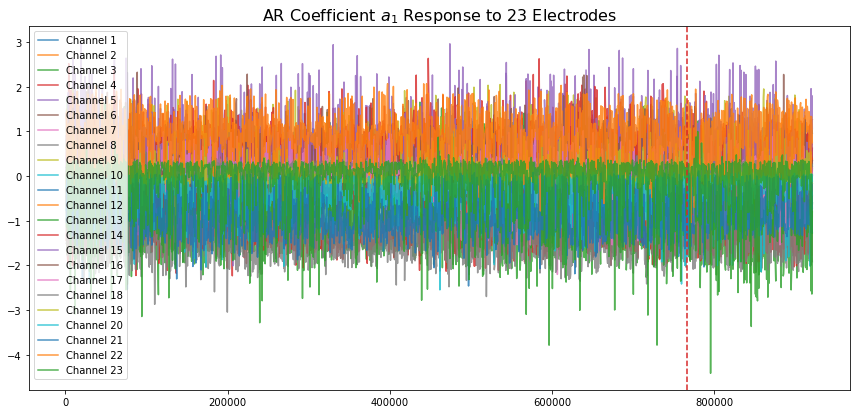

In [19]:
a_1 = ar_hats[:,:,0]   # select first AR coefficient for all channels and for all times

plt.figure(figsize=(12,6))
for i in range(n_c):
    plt.plot(ar_index, a_1[:,i], label=f'Channel {(i+1)}', alpha=0.8)
plt.axvline(x=seizure_start_index, color='tab:red', ls='--')
plt.legend(loc=2)
plt.title(r'AR Coefficient $a_1$ Response to 23 Electrodes', fontsize=16)
plt.tight_layout()
plt.show()

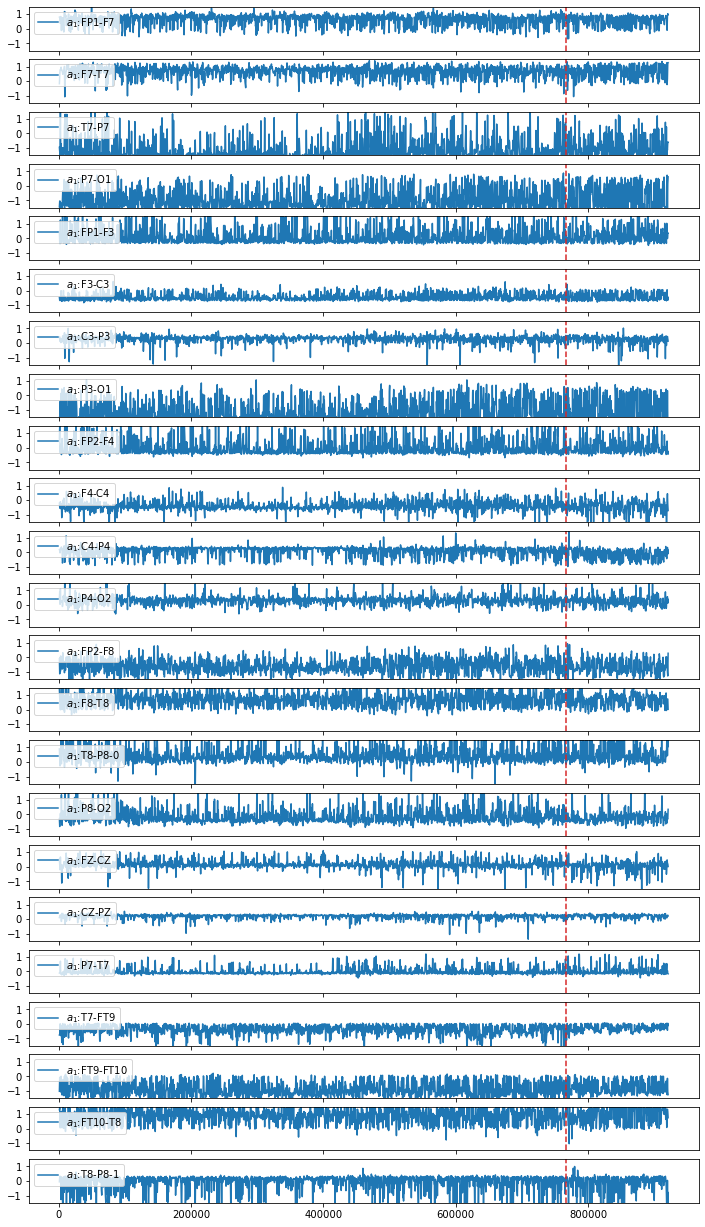

In [40]:
# same plot as above, but in separate subplots
fig, axes = plt.subplots(figsize=(12,22), nrows=n_c, sharex=True)
for i, ax in enumerate(axes):
    ax.plot(ar_index, a_1[:,i], label=f'$a_1$:{ch_names[i]}')
    ax.set_ylim([-1.5, 1.5])
    ax.legend(loc=2)
    ax.axvline(x=seizure_start_index, color='tab:red', ls='--')
plt.show()